# Implementing NFT Demand Prediction System with SageMaker Built-In Algorithm Using Factorization Machines: Part 2

# Table of Contents

* [Chapter 1](#chapter1): Setup

* [Chapter 2](#chapter2): Data
    * [2.1](#2_1): Explore
    * [2.2](#2_2): Clean
    * [2.3](#2_3): Preprocess
 
* [Chapter 3](#chapter3): Regressor Training

* [Chapter 4](#chapter4): Inference
    * [4.1](#4_1): Batch inference
    * [4.2](#4_2): Real-time inference

* [Chapter 5](#chapter5): Model Performance Evaluation

* [Chapter 6](#chapter5): Model Tuning
    * [6.1](#6_1): Setting hyperparameters
    * [6.2](#6_2): Tracking hyperparameter tuning job
    * [6.3](#6_3): Analysis of fine-tuning

* [Chapter 7](#chapter7): Clean-up

---

## Chapter 1: <a class="anchor" id="chapter1"></a> Setup

In [92]:
import boto3
import sagemaker

from sagemaker.tuner import HyperparameterTuner, ContinuousParameter
from sagemaker.analytics import HyperparameterTuningJobAnalytics, TrainingJobAnalytics

bucket = 'sagemaker-us-west-2-369454669781'
prefix = 'sagemaker/fm-recsys'
role = 'arn:aws:iam::369454669781:role/service-role/AmazonSageMaker-ExecutionRole-20220415T151752'

sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

In [93]:
#Essentials
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import pandas as pd
from pandas import Series, DataFrame
from pandas.api.types import CategoricalDtype
pd.options.display.max_columns = None
import numpy as np; np.random.seed(2022)
import random

#Image creation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib import pyplot
import plotly.express as px
import plotly.graph_objects as go

#Image display
from IPython.display import Image as image
from IPython.display import display

#Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

#Metrics of accuracy
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import mean
from numpy import std

#Other
import psycopg2 as pg
from nbformat import current
import itertools as it
import io
import os
import sys
import time
from scipy.sparse import lil_matrix
import boto3
import json
import sagemaker.amazon.common as smac
from sagemaker.predictor import json_deserializer

In [94]:
# plot aesthetics
sns.set(color_codes=True)
sns.set_context('paper')
five_thirty_eight = ["#30a2da", "#fc4f30", "#e5ae38", "#6d904f", "#8b8b8b",]
sns.set_palette(five_thirty_eight)

%matplotlib inline

## Chapter 2: <a class="anchor" id="chapter2"></a> Data

### 2.1  <a class="anchor" id="2_1"></a> Explore

In [95]:
engine = pg.connect("dbname='opensea' user='marfapopova21' host='opensea.c5pkb2dzarva.us-west-2.rds.amazonaws.com' port='5432' password='qwerty123'")
df1 = pd.read_sql('select * from nfts.collections', con=engine)
df1 = df1.dropna(how='all', axis=1)
df1 = df1.dropna(how='all')
df1.head()
len(df1)

/usr/local/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,collection_name,created_date,collection_status,nft_version,tokens,owner_number,featured,hidden,nsfw
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False
1,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,3050053.0,False,False,False
2,3ASTER EGGZ,2022-04-12T17:49:14.605766,not_requested,None,0,7471608.0,False,False,False
3,Testv2chib2,2022-04-12T17:51:35.428359,not_requested,None,0,5909669.0,False,False,False
4,Test Model 4,2022-04-12T17:50:33.114878,not_requested,3.0,None,7396100.0,False,False,False


7500

In [96]:
engine = pg.connect("dbname='opensea' user='marfapopova21' host='opensea.c5pkb2dzarva.us-west-2.rds.amazonaws.com' port='5432' password='qwerty123'")
df2 = pd.read_sql('select * from nfts.finances', con=engine)
df2 = df2.dropna(how='all', axis=1)
df2 = df2.dropna(how='all')
df2.head()
len(df2)

/usr/local/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,collection_name,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,max_price,min_price,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
1,test,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
2,3ASTER EGGZ,non-fungible,False,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,False,False,0,250
3,Testv2chib2,non-fungible,False,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,False,False,0,250
4,Test Model 4,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250


7500

In [97]:
# Merge the 2 dataframes on collection name
df = pd.merge(df1, df2, on = 'collection_name')
df.head()
len(df)

,collection_name,created_date,collection_status,nft_version,tokens,owner_number,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,max_price,min_price,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
1,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,7356207.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,False,False,0,250
2,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,7461686.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250
3,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,7461686.0,False,False,False,semi-fungible,False,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,False,False,0,250
4,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,3050053.0,False,False,False,non-fungible,False,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,False,False,0,250


596130

In [98]:
df.columns

Index(['collection_name', 'created_date', 'collection_status', 'nft_version',
       'tokens', 'owner_number', 'featured', 'hidden', 'nsfw',
       'asset_contract_type', 'require_email', 'day_avg_price',
       'week_avg_price', 'month_avg_price', 'total_volume', 'total_sales',
       'total_supply', 'max_price', 'min_price', 'average_price',
       'only_proxied_transfers', 'is_subject_to_whitelist',
       'opensea_buyer_fee_basis_points', 'opensea_seller_fee_basis_points'],
      dtype='object')

In [99]:
df = df.drop(['owner_number', 'max_price', 'min_price'], axis=1)
len(df)

596130

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596130 entries, 0 to 596129
Data columns (total 21 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   collection_name                  455505 non-null  object 
 1   created_date                     455505 non-null  object 
 2   collection_status                596130 non-null  object 
 3   nft_version                      84029 non-null   object 
 4   tokens                           80345 non-null   object 
 5   featured                         596130 non-null  bool   
 6   hidden                           596130 non-null  bool   
 7   nsfw                             596130 non-null  bool   
 8   asset_contract_type              455505 non-null  object 
 9   require_email                    596130 non-null  bool   
 10  day_avg_price                    596130 non-null  float64
 11  week_avg_price                   596130 non-null  float64
 12  mo

In [101]:
df['collection_name'].nunique()

3314

In [102]:
df['collection_name'].value_counts(ascending=False)

Unidentified contract    326041
CryptoPunks               26244
Pawn Tickets              23409
SquareNFT                 14641
Pawn Loans                 9025
                          ...  
test collection               1
Test NFT CORE                 1
Lord Ganesha                  1
OneCDNFT                      1
TheImaginaryOnesNft           1
Name: collection_name, Length: 3314, dtype: int64

In [103]:
df['collection_name'].value_counts().loc[lambda x : x<326041] 

CryptoPunks            26244
Pawn Tickets           23409
SquareNFT              14641
Pawn Loans              9025
UTPN                    7396
                       ...  
test collection            1
Test NFT CORE              1
Lord Ganesha               1
OneCDNFT                   1
TheImaginaryOnesNft        1
Name: collection_name, Length: 3313, dtype: int64

In [104]:
# Difference between the number of all collection records in the dataset and unnamed ones
596130 - 326041

270089

Collections named "Unidentified contract" mean that their creators did not add public variable string. Hence, there are only 3313 unique collection names in the dataset, that contain 270089 labelled records.

### 2.2  <a class="anchor" id="2_2"></a> Clean

In [105]:
df = df.drop_duplicates()
print("Number of records after removing duplicates = {:10d}".format(df.shape[0]))

Number of records after removing duplicates =      41681


In [106]:
# Show number of all existing data types in the dataframe
print(df.dtypes.astype(str).value_counts())

object     8
float64    7
bool       6
dtype: int64


In [107]:
df.select_dtypes(include='object')

,collection_name,created_date,collection_status,nft_version,tokens,asset_contract_type,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,semi-fungible,0,250
1,Dispatch-Messaging,2022-04-06T21:49:20.343522,not_requested,None,None,semi-fungible,0,250
2,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,semi-fungible,0,250
3,Dispatch-Messaging,2022-04-11T12:25:09.603872,not_requested,None,None,semi-fungible,0,250
4,test,2022-04-12T17:54:03.412074,not_requested,3.0,1,non-fungible,0,250
...,...,...,...,...,...,...,...,...
596125,AmazingToyMachine,2022-04-10T22:20:19.642343,not_requested,3.0,0,non-fungible,0,250
596126,SR49,2022-04-10T22:27:58.964315,not_requested,3.0,0,non-fungible,0,250
596127,Plunge2PO,2022-04-10T22:26:58.976898,not_requested,3.0,None,non-fungible,0,250
596128,Cheese,2022-04-10T22:26:03.694412,not_requested,3.0,2,non-fungible,0,250


In [108]:
df['created_date'] = pd.to_datetime(df['created_date'])

In [109]:
df['created_date']

0        2022-04-06 21:49:20.343522
1        2022-04-06 21:49:20.343522
2        2022-04-11 12:25:09.603872
3        2022-04-11 12:25:09.603872
4        2022-04-12 17:54:03.412074
                    ...            
596125   2022-04-10 22:20:19.642343
596126   2022-04-10 22:27:58.964315
596127   2022-04-10 22:26:58.976898
596128   2022-04-10 22:26:03.694412
596129   2022-04-10 22:25:38.740942
Name: created_date, Length: 41681, dtype: datetime64[ns]

In [110]:
df['year'] = pd.DatetimeIndex(df['created_date']).year
df['month'] = pd.DatetimeIndex(df['created_date']).month

In [111]:
df['year'].value_counts()

2022.0    41573
Name: year, dtype: int64

In [112]:
df['month'].value_counts()

4.0    41320
3.0      250
1.0        2
2.0        1
Name: month, dtype: int64

In [113]:
df.drop(columns = ['year', 'month', 'created_date'], inplace = True)

In [114]:
df['collection_status'].replace(['not_requested', 'requested', 'approved','verified'], [0,1,2,3], inplace=True)
df['collection_status'].value_counts()

0    41681
Name: collection_status, dtype: int64

In [115]:
df['asset_contract_type'].value_counts()

non-fungible     22107
semi-fungible    19466
Name: asset_contract_type, dtype: int64

In [116]:
df['asset_contract_type'].replace(['non-fungible', 'semi-fungible'], [0,1], inplace=True)
df['asset_contract_type'].value_counts()

0.0    22107
1.0    19466
Name: asset_contract_type, dtype: int64

In [117]:
df = df[df['nft_version'].notna()]
df = df[df['tokens'].notna()]

try:
  df['nft_version'] = df['nft_version'].astype(float)
  df['tokens'] = df['tokens'].astype(int)
except:
  print("Something went wrong")

In [118]:
try:
  df['opensea_buyer_fee_basis_points'] = df['opensea_buyer_fee_basis_points'].astype(float)
  df['opensea_seller_fee_basis_points'] = df['opensea_seller_fee_basis_points'].astype(float)
except:
  print("Something went wrong")

In [119]:
df.select_dtypes(include='object')
print(df.dtypes.astype(str).value_counts())

,collection_name
4,test
8,test
10,test
11,test
12,test
...,...
596119,RESPEK
596123,Boba
596125,AmazingToyMachine
596126,SR49


float64    11
bool        6
int64       2
object      1
dtype: int64


In [120]:
# Descriptive statistics of the transposed table
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
collection_status,7044.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
nft_version,7044.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
tokens,7044.0,88.111584,1422.531819,0.0,0.0,0.0,1.0,66049.0
asset_contract_type,7044.0,0.149631,0.356735,0.0,0.0,0.0,0.0,1.0
day_avg_price,7044.0,0.001932,0.023346,0.0,0.0,0.0,0.0,1.0
week_avg_price,7044.0,0.016440,0.359766,0.0,0.0,0.0,0.0,10.0
month_avg_price,7044.0,0.016440,0.359766,0.0,0.0,0.0,0.0,10.0
total_volume,7044.0,0.019455,0.368701,0.0,0.0,0.0,0.0,10.0
total_sales,7044.0,0.145798,0.857873,0.0,0.0,0.0,0.0,10.0
total_supply,7044.0,80.552953,582.430158,0.0,2.0,5.0,13.0,10000.0


### 2.3  <a class="anchor" id="2_3"></a> Preprocess

#### 2.3.1  <a class="anchor" id="2_3_1"></a> Data scaling

In [122]:
# Scale the explanatory variables
from sklearn.preprocessing import RobustScaler
stratified_df = df.drop(columns = ['collection_name'])
stratified_df = pd.DataFrame(RobustScaler().fit_transform(stratified_df), columns=stratified_df.columns)
stratified_df 

,collection_status,nft_version,tokens,featured,hidden,nsfw,asset_contract_type,require_email,day_avg_price,week_avg_price,month_avg_price,total_volume,total_sales,total_supply,average_price,only_proxied_transfers,is_subject_to_whitelist,opensea_buyer_fee_basis_points,opensea_seller_fee_basis_points
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.363636,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.454545,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
7040,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.272727,0.0,0.0,0.0,0.0,0.0
7041,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.181818,0.0,0.0,0.0,0.0,0.0
7042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.090909,0.0,0.0,0.0,0.0,0.0


####

#### 2.3.2  <a class="anchor" id="2_3_2"></a>  Data splitting

In [42]:
train_df, validate_df, test_df = np.split(stratified_df .sample(frac=1), [int(.6*len(stratified_df )), int(.8*len(stratified_df ))])

In [43]:
print("Number of rows in the training data set   = {:10d}".format(train_df.shape[0]))
print("Number of rows in the validation data set = {:10d}".format(validate_df.shape[0]))
print("Number of rows in the test data set       = {:10d}".format(test_df.shape[0]))

Number of rows in the training data set   =       4226
Number of rows in the validation data set =       1409
Number of rows in the test data set       =       1409


In [44]:
# get feature dimension

all_df = pd.concat([train_df, validate_df, test_df])
# Choose a response variable
Y = all_df['total_sales']

# Drop a response variable and collection name from the feature data set
X = all_df.drop(columns = ['total_sales'])

nb_total_sales = np.unique(Y.values).shape[0]
nb_independent_vars = np.unique(X.values).shape[0]
feature_dim = nb_total_sales + nb_independent_vars
print("Number of demand levels          = {:10d}".format(nb_total_sales))
print("Number of independent variables  = {:10d}".format(nb_independent_vars))
print("Number of features               = {:10d}".format(feature_dim))

Number of demand levels          =          8
Number of independent variables  =        220
Number of features               =        228


#### 2.3.3  <a class="anchor" id="2_3_3"></a>  Building Sparse One-Hot Encoded Matrix

In [45]:
def convert_sparse_matrix(df, nb_rows, nb_total_sales, nb_independent_vars):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_total_sales + nb_independent_vars
    print("# of rows = {}".format(str(nb_rows)))
    print("# of cols = {}".format(str(nb_cols)))

    # extract customers and ratings
    df_X = df_val[:, 0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:, 1] = nb_total_sales + df_X[:, 1]
    coords = df_X[:, 0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # create label with ratings
    Y = df_val[:, 2].astype('float32')

    # validate size and shape
    print(X.shape)
    print(Y.shape)
    assert X.shape == (nb_rows, nb_cols)
    assert Y.shape == (nb_rows, )

    return X, Y

In [46]:
print("Convert training data set to one-hot encoded sparse matrix")
train_X, train_Y = convert_sparse_matrix(train_df, train_df.shape[0], nb_total_sales, nb_independent_vars)
print("Convert validation data set to one-hot encoded sparse matrix")
validate_X, validate_Y = convert_sparse_matrix(validate_df, validate_df.shape[0], nb_total_sales, nb_independent_vars)
print("Convert test data set to one-hot encoded sparse matrix")
test_X, test_Y = convert_sparse_matrix(test_df, test_df.shape[0], nb_total_sales, nb_independent_vars)

Convert training data set to one-hot encoded sparse matrix
# of rows = 4226
# of cols = 228
(4226, 228)
(4226,)
Convert validation data set to one-hot encoded sparse matrix
# of rows = 1409
# of cols = 228
(1409, 228)
(1409,)
Convert test data set to one-hot encoded sparse matrix
# of rows = 1409
# of cols = 228
(1409, 228)
(1409,)


#### 2.3.4  <a class="anchor" id="2_3_4"></a> Convert to Protobuf format and Upload to S3

In [47]:
def save_as_protobuf(X, Y, bucket, key):
    """Converts features and predictions matrices to recordio protobuf and
       writes to S3

    Args:
        X:
          2D numpy matrix with features
        Y:
          1D numpy matrix with predictions
        bucket:
          s3 bucket where recordio protobuf file will be staged
        prefix:
          s3 url prefix to stage prepared data to use for training the model
        key:
          protobuf file name to be staged

    Returns:
        s3 url with key to the protobuf data
    """
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}'.format(key)
    boto3.resource('s3', region_name='us-west-2').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [48]:
s3_train_path = save_as_protobuf(train_X, train_Y, bucket, 'prepare/train/train.protobuf')
print("Training data set in protobuf format uploaded at {}".format(s3_train_path))
s3_val_path = save_as_protobuf(validate_X, validate_Y, bucket, 'prepare/validate/validate.protobuf')
print("Validation data set in protobuf format uploaded at {}".format(s3_val_path))

Training data set in protobuf format uploaded at s3://sagemaker-us-west-2-369454669781/prepare/train/train.protobuf
Validation data set in protobuf format uploaded at s3://sagemaker-us-west-2-369454669781/prepare/validate/validate.protobuf


In [49]:
def chunk(x, batch_size):
    """split array into chunks of batch_size
    """
    chunk_range = range(0, x.shape[0], batch_size)
    chunks = [x[p: p + batch_size] for p in chunk_range]
    return chunks

In [50]:
test_x_chunks = chunk(test_X, 10000)
test_y_chunks = chunk(test_Y, 10000)
N = len(test_x_chunks)
for i in range(N):
    test_data = save_as_protobuf(
        test_x_chunks[i],
        test_y_chunks[i],
        bucket,
        "prepare/test/test_" + str(i) + ".protobuf")
    print(test_data)

s3://sagemaker-us-west-2-369454669781/prepare/test/test_0.protobuf


## Chapter 3: <a class="anchor" id="chapter3"></a> Regressor Training

In [51]:
from sagemaker.amazon.amazon_estimator import get_image_uri
container = get_image_uri(boto3.Session().region_name, 'factorization-machines')

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [52]:
%time

output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

fm = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

fm.set_hyperparameters(feature_dim=228,
                      predictor_type='regressor',
                      mini_batch_size=200,
                      num_factors=64,
                      bias_lr=0.02,
                      epochs=10)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.96 µs


In [53]:
fm.fit({'train': s3_train_path,'test': s3_val_path}, wait=False)

In [54]:
training_job_name = fm._current_job_name
metric_name = 'train:rmse:epoch'

In [59]:
# run this cell to check current status of training job
fm_training_job_result = smclient.describe_training_job(TrainingJobName=training_job_name)

status = fm_training_job_result['TrainingJobStatus']
if status != 'Completed':
    print('Reminder: the training job has not been completed.')
else:
    print('The training job is completed.')

The training job is completed.


In [123]:
# Plug-in the training job name and metrics to be captured
rmse_dataframe = TrainingJobAnalytics(training_job_name=training_job_name,metric_names=[metric_name]).dataframe()
rmse_dataframe

,timestamp,metric_name,value
0,0.0,train:rmse:epoch,1209.996144


In [124]:
# Let's see all metrics captured
all_metrics_dataframe = TrainingJobAnalytics(training_job_name=training_job_name).dataframe()
all_metrics_dataframe

,timestamp,metric_name,value
0,0.0,train:rmse:epoch,1.209996e+03
1,0.0,train:progress,1.000000e+02
2,0.0,test:mse,2.535042e+05
3,0.0,train:mse:batch,7.385864e+05
4,0.0,train:absolute_loss:epoch,8.052339e+01
5,0.0,test:absolute_loss,4.933010e+01
6,0.0,train:mse,1.464091e+06
7,0.0,train:mse:epoch,1.464091e+06
8,0.0,train:rmse:batch,8.594105e+02
9,0.0,train:rmse,1.209996e+03


In [61]:
def convert_to_protobuf(X, Y=None):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    return buf

In [62]:
def convert_sparse_matrix_X(df, nb_rows, nb_demand_levels, nb_independent_vars):
    # dataframe to array
    df_val = df.values

    # determine feature size
    nb_cols = nb_demand_levels + nb_independent_vars
    
    # extract customers and ratings
    df_X = df_val[:,0:2]
    # Features are one-hot encoded in a sparse matrix
    X = lil_matrix((nb_rows, nb_cols)).astype('float32')
    df_X[:,1] = nb_demand_levels + df_X[:,1]
    coords = df_X[:,0:2]
    X[np.arange(nb_rows), coords[:, 0]] = 1
    X[np.arange(nb_rows), coords[:, 1]] = 1

    # validate size and shape
    assert X.shape == (nb_rows, nb_cols)
    
    return X

---

## Chapter 4: <a class="anchor" id="chapter4"></a> Inference

### 4.1  <a class="anchor" id="4_1"></a> Batch Inference

In [63]:
fm_model = fm.create_model()

In [64]:
fm_transformer = fm_model.transformer(
    instance_type='ml.c4.xlarge', 
    instance_count=1, 
    strategy="MultiRecord", 
    output_path="s3://{}/transform/".format(bucket)
)

In [65]:
fm_transformer.transform(
    data="s3://{}/prepare/test/".format(bucket), 
    data_type='S3Prefix', 
    content_type="application/x-recordio-protobuf")

..........................
Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: i

In [66]:
print('Waiting for transform job: ' + fm_transformer.latest_transform_job.job_name)
fm_transformer.wait()

Waiting for transform job: factorization-machines-2022-04-25-17-01-35-985
Docker entrypoint called with argument(s): serve
Running default environment configuration script
Docker entrypoint called with argument(s): serve
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorith

In [67]:
def download_from_s3(bucket, key):
    s3 = boto3.resource('s3')
    obj = s3.Object( bucket, key)
    content = obj.get()['Body'].read()
    return content

In [68]:
test_preds = []
for i in range(N):
    key = 'transform/test_' + str(i) + '.protobuf.out'
    response = download_from_s3(bucket, key)
    result = [json.loads(row)['score'] for row in response.split(b'\n') if len(row) > 0]
    test_preds.extend(result)

In [69]:
test_preds = np.array(test_preds)

In [70]:
test_preds.shape

(1409,)

### 4.2  <a class="anchor" id="4_2"></a> Real-Time Inference

In [ ]:
#fm_predictor = fm.deploy(initial_instance_count=1, instance_type="ml.m4.xlarge")

In [ ]:
fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge"
)

-------!

In [ ]:
#fm_predictor.content_type = 'application/x-recordio-protobuf'

In [ ]:
test_pb = convert_to_protobuf(test_X[1000:1010]).getvalue()

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received client error (415) from primary with message "content-type application/octet-stream not supported". See https://us-west-2.console.aws.amazon.com/cloudwatch/home?region=us-west-2#logEventViewer:group=/aws/sagemaker/Endpoints/factorization-machines-2022-04-19-14-56-40-628 in account 369454669781 for more information.

In [ ]:
#response = fm_predictor.predict(test_pb)
#predicted = [round(r['score'], 2) for r in json.loads(response)['predictions']]
#results_df = pd.DataFrame(zip(test_Y[1000:1010], predicted), columns = ["actual_rating", "predicted_rating"])
#results_df

---

## Chapter 5: <a class="anchor" id="chapter5"></a> Model Performance Evaluation

In [72]:
print('Naive MSE:', np.mean((test_df['total_sales'] - np.mean(train_df['total_sales'])) ** 2))

Naive MSE: 0.7971301999766911


In [73]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

MSE: 5325416.736594219


---

## Chapter 6: <a class="anchor" id="chapter"></a> Model Tuning

### 6.1  <a class="anchor" id="6_1"></a> Setting hyperparameters

In [74]:
output_location = 's3://{}/train/'.format(bucket)
s3_train_path = 's3://{}/prepare/train/train.protobuf'.format(bucket)
s3_val_path = 's3://{}/prepare/validate/validate.protobuf'.format(bucket)

In [75]:
fm_estimator = sagemaker.estimator.Estimator(container,
                                   role, 
                                   train_instance_count=1, 
                                   train_instance_type='ml.c5.4xlarge',
                                   output_path=output_location,
                                   sagemaker_session=sess)

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [77]:
# Setting the parameters that worked in model training.
fm_estimator.set_hyperparameters(
    feature_dim=228,
    predictor_type='regressor',
    mini_batch_size=200,
    num_factors=512,
    bias_lr=0.02,
    epochs=20)

In [78]:
hyperparameter_ranges=  {
    "factors_lr": ContinuousParameter(0.0001, 0.2),
    "factors_init_sigma": ContinuousParameter(0.0001, 1)
}

In [79]:
objective_metric_name = "test:rmse"
objective_type = "Minimize"

In [80]:
fm_tuner = HyperparameterTuner(
    estimator=fm_estimator,
    objective_metric_name=objective_metric_name, 
    hyperparameter_ranges=hyperparameter_ranges,
    objective_type=objective_type,
    max_jobs=10,
    max_parallel_jobs=2
)

In [81]:
timestamp_prefix = time.strftime("%Y%m%d-%H%M%S", time.gmtime())
fm_tuner_job_name = 'hpo-fm-' + timestamp_prefix

In [82]:
fm_tuner.fit({'train': s3_train_path, 'test': s3_val_path}, job_name=fm_tuner_job_name, wait=False)

### 6.2  <a class="anchor" id="6_2"></a> Tracking hyperparameter tuning job

In [85]:
tuning_job_result = smclient.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=fm_tuner_job_name)

status = tuning_job_result['HyperParameterTuningJobStatus']
if status != 'Completed':
    print('Reminder: the tuning job has not been completed.')
    
job_count = tuning_job_result['TrainingJobStatusCounters']['Completed']
print("%d training jobs have completed" % job_count)
    
is_minimize = (tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['Type'] != 'Maximize')
objective_name = tuning_job_result['HyperParameterTuningJobConfig']['HyperParameterTuningJobObjective']['MetricName']

10 training jobs have completed


### 6.3  <a class="anchor" id="6_3"></a> Analysis of fine-tuning

In [84]:
# Plug-in the training job name and metrics to be captured
fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()
df_fm_tuner_metrics

,factors_init_sigma,factors_lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.864814,0.000432,hpo-fm-20220426-114119-010-4581dd43,Completed,501.625000,2022-04-26 12:54:51+01:00,2022-04-26 12:55:49+01:00,58.0
1,0.575173,0.000458,hpo-fm-20220426-114119-009-3fea7a6e,Completed,501.626862,2022-04-26 12:55:02+01:00,2022-04-26 12:55:56+01:00,54.0
2,0.000859,0.000581,hpo-fm-20220426-114119-008-ac304532,Completed,501.710876,2022-04-26 12:52:10+01:00,2022-04-26 12:53:07+01:00,57.0
3,0.000124,0.000181,hpo-fm-20220426-114119-007-82f5e08b,Completed,502.937500,2022-04-26 12:52:19+01:00,2022-04-26 12:53:17+01:00,58.0
4,0.078577,0.000117,hpo-fm-20220426-114119-006-7c66c90e,Completed,503.045319,2022-04-26 12:49:17+01:00,2022-04-26 12:50:45+01:00,88.0
5,0.296787,0.000260,hpo-fm-20220426-114119-005-503f1883,Completed,502.277344,2022-04-26 12:49:15+01:00,2022-04-26 12:50:13+01:00,58.0
6,0.000230,0.001333,hpo-fm-20220426-114119-004-f04364c0,Completed,502.424652,2022-04-26 12:46:00+01:00,2022-04-26 12:47:12+01:00,72.0
7,0.064663,0.001300,hpo-fm-20220426-114119-003-14dd4ab5,Completed,502.340912,2022-04-26 12:45:57+01:00,2022-04-26 12:47:09+01:00,72.0
8,0.001025,0.002845,hpo-fm-20220426-114119-002-56c62b71,Completed,502.823608,2022-04-26 12:42:43+01:00,2022-04-26 12:44:05+01:00,82.0
9,0.030907,0.191862,hpo-fm-20220426-114119-001-1ce661a7,Completed,503.270477,2022-04-26 12:42:43+01:00,2022-04-26 12:44:05+01:00,82.0


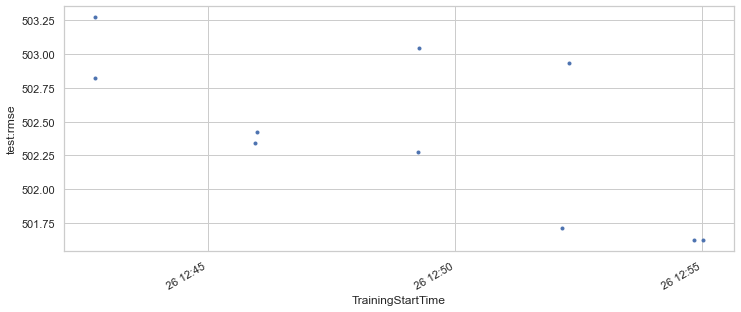

In [86]:
# Analyze using Seaborn
plt = df_fm_tuner_metrics.plot(kind='line', figsize=(12,5), x='TrainingStartTime', 
                             y='FinalObjectiveValue', 
                             style='b.', legend=False)
plt.set_ylabel(objective_metric_name);

In [87]:
print("fm_tuner_job_name: " + fm_tuner_job_name)
fm_tuner = HyperparameterTuner.attach(fm_tuner_job_name)

fm_tuner_analytics = HyperparameterTuningJobAnalytics(hyperparameter_tuning_job_name=fm_tuner_job_name)
df_fm_tuner_metrics = fm_tuner_analytics.dataframe()

fm_best_model_name = fm_tuner.best_training_job()
print("fm_best_model_name: " + fm_best_model_name)

fm_model_info = smclient.describe_training_job(TrainingJobName=fm_best_model_name)

fm_tuner_job_name: hpo-fm-20220426-114119
fm_best_model_name: hpo-fm-20220426-114119-010-4581dd43


In [88]:
df_fm_tuner_metrics[df_fm_tuner_metrics['TrainingJobName']==fm_best_model_name]

,factors_init_sigma,factors_lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.864814,0.000432,hpo-fm-20220426-114119-010-4581dd43,Completed,501.625,2022-04-26 12:54:51+01:00,2022-04-26 12:55:49+01:00,58.0


In [89]:
fm = sagemaker.estimator.Estimator.attach(fm_best_model_name)


2022-04-26 11:55:49 Starting - Preparing the instances for training
2022-04-26 11:55:49 Downloading - Downloading input data
2022-04-26 11:55:49 Training - Training image download completed. Training in progress.
2022-04-26 11:55:49 Uploading - Uploading generated training model
2022-04-26 11:55:49 Completed - Training job completed


In [90]:
print('MSE:', np.mean((test_Y - test_preds) ** 2))

MSE: 5325416.736594219


## Chapter 7: <a class="anchor" id="chapter7"></a> Clean-up

In [91]:
# Deletes our endpoint to avoid stray hosting charges
endpoint_name_contains = ['-fm-', 'factorization-machines-']
for name in endpoint_name_contains:
    endpoints = smclient.list_endpoints(NameContains=name, StatusEquals='InService')
    endpoint_names = [r['EndpointName'] for r in endpoints['Endpoints']]
    for endpoint_name in endpoint_names:
        print("Deleting endpoint: " + endpoint_name)
        smclient.delete_endpoint(EndpointName=endpoint_name)